<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINE

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
data_size = 20000
cor = [0.5, 1, 1.5, 2.5, 3]

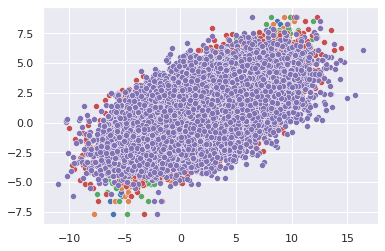

In [5]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,6))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

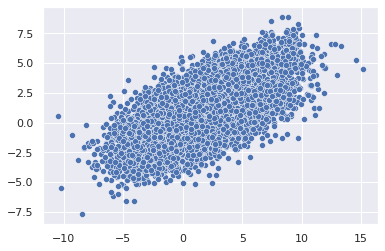

In [6]:
for i in range(200):
    os = i*100
    x[os:os+100,4] = y[os:os+100] + np.random.normal(1,1+(i/100),100)
    x[os:os+100,5] = i
sns.scatterplot(x=x[:,4],y=y)

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
mi_scores = make_mi_scores(pd.DataFrame(x,columns=['x0','x1','x2','x3','x4','ix']), y, discrete_features="auto")
print(mi_scores)

x0    1.417025
x1    0.803768
x2    0.510813
x4    0.321892
x3    0.251627
ix    0.000000
Name: MI Scores, dtype: float64


In [9]:
for i in range(200):
    os = i*100
    mi_scores = make_mi_scores(pd.DataFrame(x[os:os+100,4],columns=['x4']), y[os:os+100], discrete_features="auto")
    print(i, mi_scores)

0 x4    0.720805
Name: MI Scores, dtype: float64
1 x4    0.877718
Name: MI Scores, dtype: float64
2 x4    0.878176
Name: MI Scores, dtype: float64
3 x4    0.747396
Name: MI Scores, dtype: float64
4 x4    0.666182
Name: MI Scores, dtype: float64
5 x4    0.68011
Name: MI Scores, dtype: float64
6 x4    0.721114
Name: MI Scores, dtype: float64
7 x4    0.717858
Name: MI Scores, dtype: float64
8 x4    0.575226
Name: MI Scores, dtype: float64
9 x4    0.703239
Name: MI Scores, dtype: float64
10 x4    0.581289
Name: MI Scores, dtype: float64
11 x4    0.585254
Name: MI Scores, dtype: float64
12 x4    0.429617
Name: MI Scores, dtype: float64
13 x4    0.509191
Name: MI Scores, dtype: float64
14 x4    0.790806
Name: MI Scores, dtype: float64
15 x4    0.620763
Name: MI Scores, dtype: float64
16 x4    0.713444
Name: MI Scores, dtype: float64
17 x4    0.678111
Name: MI Scores, dtype: float64
18 x4    0.804251
Name: MI Scores, dtype: float64
19 x4    0.750366
Name: MI Scores, dtype: float64
20 x4    0.

(20000, 6)
(20000, 1)


100%|██████████| 300/300 [00:07<00:00, 38.84it/s]



tensor([ 1.4238e+00,  7.8366e-01,  5.2421e-01,  2.4611e-01,  3.2006e-01,
        -3.6788e-04], grad_fn=<CopySlices>)


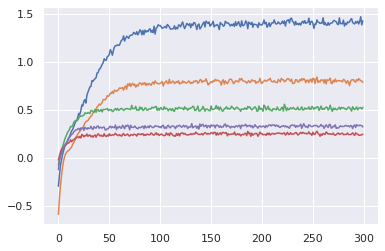

In [10]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = [Net() for i in range(x.shape[1])]
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.01) for i in range(x.shape[1])]

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    back_loss = torch.zeros(6)
    s = np.random.choice(x.shape[0],minibatch)
    for i in range(x.shape[1]):
        x_sample = Variable(torch.from_numpy(x[s,i].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(model[i](x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model[i](x_sample, y_shuffle))))
        loss = - ret  # maximize
        model[i].zero_grad()
        loss.backward()
        optimizer[i].step()
        back_loss[i] = ret

    plot_loss.append(back_loss.data.numpy())


    #back_loss = loss

print('')
print(back_loss)

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[:,0])
plt.plot(plot_loss[:,1])
plt.plot(plot_loss[:,2])
plt.plot(plot_loss[:,3])
plt.plot(plot_loss[:,4])

(20000, 6)
(20000, 1)


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


tensor([ 1.5258e-04,  4.9068e-05, -6.8582e-05, -1.4735e-05, -1.4133e-05,
         4.5479e-07])
x4    0.187092
Name: MI Scores, dtype: float64
[ 1.4112115e+00  8.1418318e-01  5.2098966e-01  2.4425174e-01
  2.1896280e-01 -5.0067900e-08]


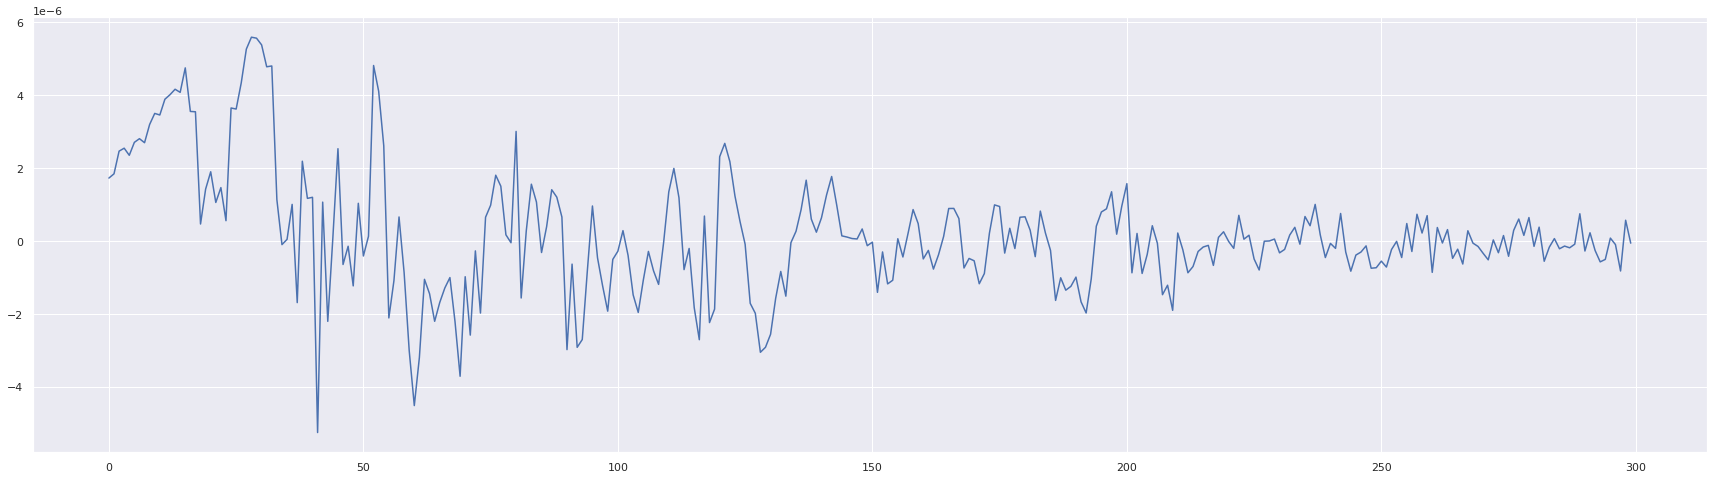

-6.317728e-08


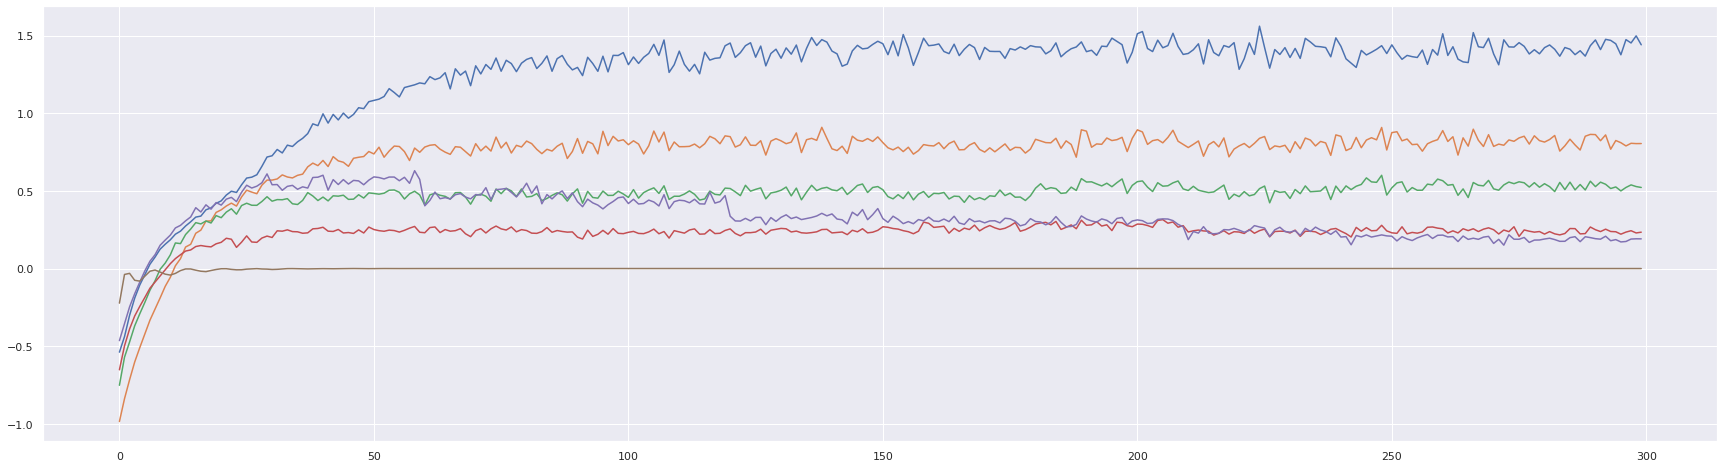

'\nchunk_loss = np.asarray(chunk_loss)\nplt.figure(figsize=(30,8))\nplt.plot(chunk_loss[:,0:4])\nplt.show()\n'

In [40]:
from tqdm import tqdm

H=20
n_epoch = 1200
minibatch = 10000

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H+1, 1))
            #self.fc4.append(nn.Linear(2, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y))
            h1 = self.fc3[i](torch.cat((h0, x[:,-1].reshape(-1,1)), 1) )
            #h2 = self.fc3[i](torch.cat((h0, x[:,-1].reshape(-1,1)), 1) )
            h.append(h1)

        return torch.cat(h, dim=1)  

model = Net(x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
chunk_loss = []
di = []
y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for chunk in tqdm(range(10)):
    for epoch in range(30):
        #i = epoch%100
        s = [*range(chunk*2000,chunk*2000+2000)]  
        #s = np.random.choice(x.shape[0],minibatch)
        x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        p_xy = model(x_sample, y_sample)
        p_x_y = model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret  # maximize

        model.zero_grad()
        x_sample.retain_grad()
        loss.mean().backward()
        optimizer.step()

        plot_loss.append(-loss.data.numpy())

        #print(torch.mean(p_xy[:,4]))
        #dx = torch.autograd.grad(ret[4], x_sample[-1,5])
        #print(p_xy.grad) #x_sample[-1,:].grad)

        di.append(torch.mean(x_sample.grad,0).data.numpy())

        #back_loss = loss
        #if i == 99:
        #    print(loss[4])
    #chunk_loss.append(-loss.data.numpy())

print(x_sample.grad[-1,:])

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4','ix'])
#df_loss.rolling(window=5).mean().plot()

di = np.asarray(di)
print(mi_scores)
print(np.mean(plot_loss[200:,:],0))

plt.figure(figsize=(30,8))
plt.plot(di[:,4])
plt.show()
print(np.mean(di[200:,0],0))

#print(x_sample.grad)
plt.figure(figsize=(30,8))
plt.plot(plot_loss[:,0:6])
plt.show()
'''
chunk_loss = np.asarray(chunk_loss)
plt.figure(figsize=(30,8))
plt.plot(chunk_loss[:,0:4])
plt.show()
'''

5.452826619148266e-05
-5.940360824267132e-06
1.7320832610130344e-05
-6.8498512109120555e-06
-0.00046050631403923045


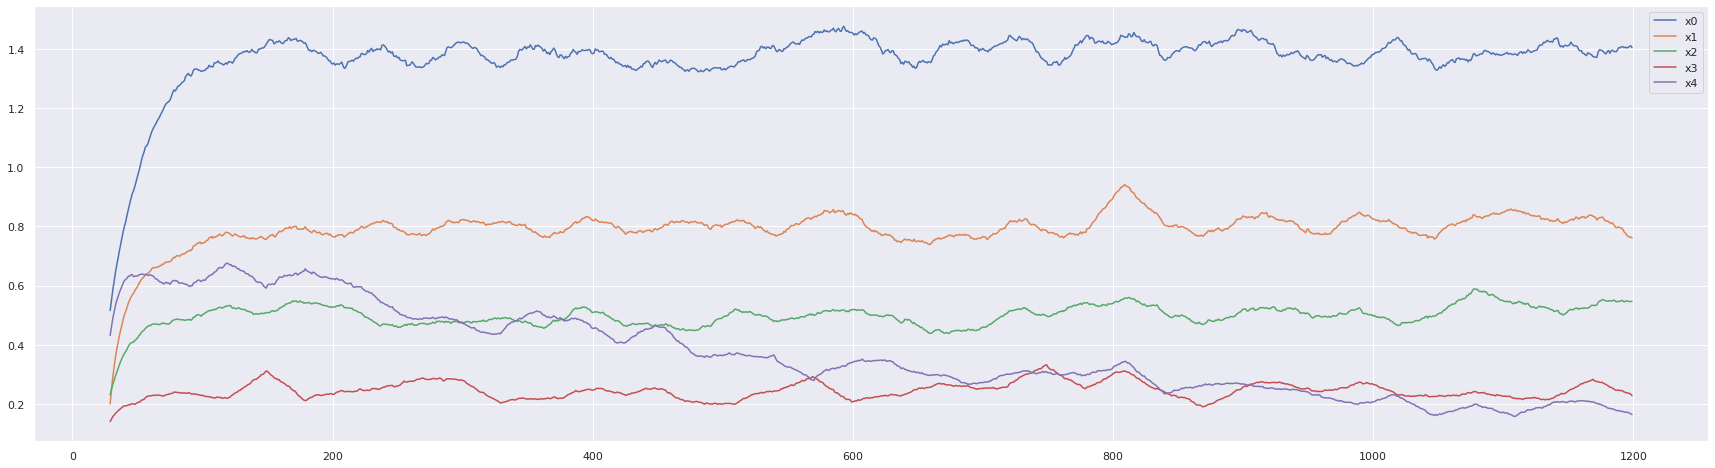

In [12]:
plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=['x0','x1','x2','x3','x4'])
df_sloss = df_loss.rolling(window=30).mean()
df_sloss.plot(figsize=(30,8))

print(np.mean(np.gradient(df_sloss[200:]['x0'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x1'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x2'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x3'].values)))
print(np.mean(np.gradient(df_sloss[200:]['x4'].values)))

In [13]:
df_sloss

,x0,x1,x2,x3,x4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1195,1.403177,0.770578,0.548346,0.237417,0.171922
1196,1.404497,0.767101,0.548130,0.237835,0.172409
1197,1.407856,0.763676,0.546197,0.235676,0.170021
1198,1.410271,0.764249,0.546874,0.233886,0.167818


In [14]:
print(np.mean(di[200:,:],0))
plt.figure(figsize=(30,8))
plt.plot(di[:,4])
plt.show()

IndexError: ignored

In [ ]:
di

+ 편미분 Test

In [ ]:
def uc(a,b):
    return a*b[0] + b[1]

In [ ]:
x = torch.tensor(100.0, requires_grad=True)
t = torch.tensor(2.0, requires_grad=True)
print(x)
print(t)
u = x**2 * t
print(u)
# 1st derivatives
#dt = torch.autograd.grad(u, t)[0]
#print(dt)
dx = torch.autograd.grad(u, x,create_graph=True)[0]
print(dx)
# 2nd derivatives (higher orders require `create_graph=True`)
ddx = torch.autograd.grad(dx, x)[0]
print(ddx)

In [ ]:
tx = torch.tensor([*range(200)],dtype=float, requires_grad=True)
ty = tx * torch.normal(1.0,0.5,size=(200,))
dx = torch.autograd.grad(torch.sum(ty), tx)[0]
print(np.mean(dx.tolist()))

In [ ]:
plt.plot(ty.detach().numpy(),'.')

In [ ]:
a = torch.rand(10, requires_grad=True)
b = torch.rand(10, requires_grad=True)

output = (2 * a).sum()

c = torch.autograd.grad(output, (a, b),allow_unused=True)
c

In [ ]:
aa = np.random.rand(3,3)
aa

In [ ]:
aa[:,[1,-1]]